In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.integrate import solve_ivp
import time
import re

# ,{
#     "sym_name": "D",
#     "Cd": 2.2,
#     "mass": 200.0,
#     "A": 5.00,
#     "radius": 1.25,
#     "active": false,
#     "slotted": false,
#     "Pm": 0,
#     "alpha": 0,
#     "alpha_active": 0,
#     "RBflag": 0,
#     "slotting_effectiveness": 0,
#     "drag_effected": true,
#     "launch_func": "launch_func_null",
#     "pmd_func": "pmd_func_none",
#     "drag_func": "drag_func_exp"
# }

def sort_key(symbol):
    match = re.match(r"([a-zA-Z_]+)(.*)kg(\d+)", symbol.name)  # Updated regex
    if match:
        name, middle_part, number = match.groups()
        return (name, middle_part, int(number))  # Sort by name, middle, then number
    match = re.match(r"([a-zA-Z_]+)(\d+)", symbol.name) # Original regex for other cases
    if match:
        name, number = match.groups()
        return (name, int(number))
    return (symbol.name,)  # For symbols without numbers

def create_vars_dict(ordered_difference_vars):
    vars_dict = {}
    for var in ordered_difference_vars:
        match = re.match(r"([a-zA-Z_]+.*kg)", str(var))  # Match up to "kg"
        if match:
            name = match.group(1) # Extract the name including "kg"
            if name not in vars_dict:
                vars_dict[name] = []
            vars_dict[name].append(var)
        else:
            match = re.match(r"([a-zA-Z_]+)(\d+)", str(var))
            if match:
                name, index = match.groups()
                if name not in vars_dict:
                    vars_dict[name] = []
                vars_dict[name].append(var)
            else: # Single variables
                vars_dict[str(var)] = [var] # Use variable name as key directly
                # if 'other_vars' not in vars_dict:
                #     vars_dict['other_vars'] = []
                # vars_dict['other_vars'].append(var)
    return vars_dict


In [2]:
# import pickle file 
with open('../scenario-properties-test-opt.pkl', 'rb') as f:
    baseline = pickle.load(f)

print(f"{baseline.species_length} species: {', '.join(baseline.species_names)}")
print(f"{baseline.n_shells} shells")
print("-----------------------------------------")
# baseline.equations

# Find the difference (symbols in equations but not in all_symbolic_vars) after 
# converting the list to a set for efficient difference calculation
difference_vars = baseline.equations.free_symbols - set(baseline.all_symbolic_vars)
ordered_difference_vars = sorted(list(difference_vars), key=sort_key)

vars_dict = create_vars_dict(ordered_difference_vars)
for name, var_list in vars_dict.items():
    print(f"{name}: {var_list}")

equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

# Parameters
N_shell = baseline.n_shells
R02 = baseline.R0_km

/Users/glavezzi/Desktop/pyssem/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


3 species: S, N, N_200.0kg
24 shells
-----------------------------------------
lambda_S: [lambda_S1, lambda_S2, lambda_S3, lambda_S4, lambda_S5, lambda_S6, lambda_S7, lambda_S8, lambda_S9, lambda_S10, lambda_S11, lambda_S12, lambda_S13, lambda_S14, lambda_S15, lambda_S16, lambda_S17, lambda_S18, lambda_S19, lambda_S20, lambda_S21, lambda_S22, lambda_S23, lambda_S24]


In [142]:
#==========================================================================
# Define symbolic variables based on loaded scenario
#==========================================================================
lam_s = vars_dict['lambda_S']
var_s = baseline.all_symbolic_vars
var_c = var_s + lam_s

equations = [sp.lambdify(var_s, eq, 'numpy') for eq in equations_flattened]
# func = sp.lambdify((var_s, np.concatenate((lam_s,)).tolist()), equations_flattened, 'numpy')

In [143]:
equations_flattened[24*2] # D_1 equation

-2.17784444521373e-8*pi*N_1*N_200.0kg_1 - 1.43989715386032e-7*pi*N_200.0kg_1**2 - 7.19948576930159e-9*pi*N_200.0kg_1*S_1 - 495.753168082602*N_200.0kg_1 + 129.324095587959*N_200.0kg_2 + 0.0125*S_1

In [144]:
equations_flattened[0] # S_1 equation

-2.17784444521373e-9*pi*N_1*S_1 - 7.19948576930159e-9*pi*N_200.0kg_1*S_1 - 1.43989715386032e-11*pi*S_1**2 - 0.125*S_1 + lambda_S1

In [145]:
equations_flattened[24]

-1.43989715386032e-9*pi*N_1**2 - 2.17784444521373e-8*pi*N_1*N_200.0kg_1 - 2.17784444521373e-9*pi*N_1*S_1 - 1983.01267233041*N_1 + 517.296382351837*N_2 + 7.19948576930159e-10*pi*(0.55*N_1**2 + 0.0666666666666667*N_10**2 + 0.0333333333333333*N_11**2 + 0.05*N_13**2 + 0.0166666666666667*N_16**2 + 0.0166666666666667*N_17**2 + 0.0166666666666667*N_18**2 + 0.0166666666666667*N_19**2 + 0.733333333333333*N_2**2 + 0.0166666666666667*N_21**2 + 0.0166666666666667*N_22**2 + 0.0166666666666667*N_23**2 + 0.35*N_3**2 + 0.25*N_4**2 + 0.15*N_5**2 + 0.166666666666667*N_6**2 + 0.1*N_7**2 + 0.0833333333333333*N_9**2) + 7.19948576930159e-8*pi*(81.9*N_200.0kg_1**2 + 3.95*N_200.0kg_10**2 + 3.28333333333333*N_200.0kg_11**2 + 2.08333333333333*N_200.0kg_12**2 + 1.9*N_200.0kg_13**2 + 1.6*N_200.0kg_14**2 + 1.46666666666667*N_200.0kg_15**2 + 1.03333333333333*N_200.0kg_16**2 + 1.15*N_200.0kg_17**2 + 1.16666666666667*N_200.0kg_18**2 + 0.75*N_200.0kg_19**2 + 79.2166666666667*N_200.0kg_2**2 + 0.616666666666667*N_200.0k

In [295]:
- 1.43989715386032 * 1e-9 * np.pi   +  7.19948576930159 * 1.13333333333333 * 1e-10 * np.pi

-1.9602138055467326e-09

In [3]:
- 2.17784444521373 * 1e-9 * np.pi + 2.17784444521373 * 1e-9 * np.pi * 77.5333333333333

5.236334217324681e-07

In [191]:
def PrfAll(x, baseline):
  """
  Python version of the PrfAll function.

  Args:
    x: Input array, where the first N_shell elements represent S_all.
    baseline: Dictionary containing data, including 'N_shell'.

  Returns:
    f: Objective function.
  """

  N_shell = baseline.n_shells
  S_all = x[:N_shell]  # Extract S_all from x

  S_all = S_all[:14]

  # print(f"PrfAll: S_all values: {S_all}")  # Add this line
  # print(f"PrfAll: np.any(S_all <= 0) {np.any(S_all <= 0)}") #Is there values less than zero?

  # HIGH CAPACITY
  f = -np.sum(np.log(S_all))
  # f = -np.sum(np.log(S_all)**2) 
  # f = -np.sum(np.log(S_all)**3) 
  # f = 1/np.sum(S_all) 

  # NOT HIGH CAPACITY
  # f = - np.sum(np.log(S_all[5:8])) # shells at 500-600 km (Python index starts at 0)
  # f = - np.sum(S_all[6]) # shell at 550 km (Python index starts at 0)

  return f

def PrCeqAll(x, fun_ceq):
    """
    Args:
      x: The optimization variables.
      baseline: Your baseline object containing symbolic variables.

    Returns:
      An array containing the results of all equality constraint function evaluations.
    """

    c_eq = np.array(fun_ceq(x)) #.flatten()

    return c_eq

def PrIneqAll(x,baseline,failure_rate_U,max_collis):
    """
    Args:
      x: The optimization variables.
      baseline: Your baseline object containing symbolic variables.

    Returns:
      An array containing the results of all inequality constraint function evaluations.
    """

    N_shell = baseline.n_shells
    S_all = x[:N_shell]
    lambda_all = x[3*N_shell:4*N_shell]
    deltat = 8
    y_fail_u = []
    # y_fail_l = []
    for i1 in range(N_shell):
    # for i1 in range(14):
      y_fail_u.append( -(lambda_all[i1] * deltat * (1 - failure_rate_U) - S_all[i1]) ) 
      # y_fail_u.append( -( lambda_all[i1] * deltat - S_all[i1] - max_collis) ) 
      # y_fail_l.append( (lambda_all[i1] * deltat * (1 - 0) - S_all[i1]) ) 
    c_ineq = y_fail_u
    # c_ineq = [y_fail_u, y_fail_l]
    # c_ineq = np.array(c_ineq).flatten()

    return c_ineq

## Initial guess
S_0 = np.ones(len(var_s[0:N_shell]))
N_0 = np.ones(len(var_s[N_shell:2*N_shell]))
D_0 = np.ones(len(var_s[2*N_shell:3*N_shell]))
lam_0 = np.ones(len(lam_s))
x0 = np.concatenate([S_0, N_0, D_0, lam_0]) * 0

## Bounds
lb_S = np.ones(len(S_0)) * 1 # 0.45
lb_N = np.ones(len(N_0)) * 1 # 0.0005
lb_D = np.ones(len(D_0)) * 1 # 0.0005
lb_l = np.ones(len(lam_0)) * 1 # 0.0005

ub_S = np.ones(len(S_0)) * np.inf
ub_N = np.ones(len(N_0)) * np.inf
ub_D = np.ones(len(D_0)) * np.inf
ub_l = np.ones(len(lam_0)) * np.inf

max_shell = 14

lb_S[max_shell:] = 0
lb_N[max_shell:] = 0
lb_D[max_shell:] = 0
lb_l[max_shell:] = 0

ub_S[max_shell:] = 1
# ub_N[max_shell:] = 0
ub_D[max_shell:] = 1
ub_l[max_shell:] = 1

lb = np.concatenate([lb_S, lb_N, lb_D, lb_l]) 
ub = np.concatenate([ub_S, ub_N, ub_D, ub_l]) 

## Farilure rate, % = fail_rate / 100
failure_rate_U = 0.1
failure_rate_U = failure_rate_U/100
max_collis = 50

## Objective function
objective = PrfAll

## Constraints for SLSQP
f3 = equations_flattened
fun_ceq = sp.lambdify((var_c,), f3, 'numpy')
con1 = {'type': 'eq', 'fun': lambda x: PrCeqAll(x, fun_ceq)}
con2 = {'type': 'ineq', 'fun': lambda x: PrIneqAll(x,baseline,failure_rate_U,max_collis)}
nonlcon = [con1, con2]

## Options for SLSQP
options = {
    'disp': True,   
    'maxiter': 5e5, # 5e5 (orig)
    'ftol': 1e-9, # -6 (orig) ; -9 (works better)       
    'eps': 1e-18, # -18 (orig)
    # 'finite_diff_rel_step': 1e-12,     
}

## Perform the optimization
start_time = time.time()
result = minimize(objective, x0, args=(baseline), method='SLSQP', 
                  jac='cs', hess=None, hessp=None, # 'cs'
                  bounds = Bounds(lb=lb, ub=ub, keep_feasible=True), 
                  constraints = nonlcon,
                  options = options)
cpu_time = time.time() - start_time
print(f"Optimization time: {cpu_time:.4f} seconds")

## Print the results
# print("Optimal found at:", result.x)
print("Function value at optimal:", -result.fun)
# print("Equality constraints:", np.array([sp.lambdify(var_c, eq, 'numpy')(*result.x) for eq in equations_flattened]))
result

Optimization terminated successfully    (Exit mode 0)
            Current function value: -141.62423508505154
            Iterations: 1518
            Function evaluations: 150629
            Gradient evaluations: 1517
Optimization time: 65.8559 seconds
Function value at optimal: 141.62423508505154


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -141.62423508505154
       x: [ 9.568e+04  9.520e+04 ...  4.563e-11  2.907e-08]
     nit: 1518
     jac: [-1.045e-05 -1.050e-05 ... -0.000e+00 -0.000e+00]
    nfev: 150629
    njev: 1517

/var/folders/8r/pmy63vtd1lbbfd8ptmtgcr4w0000gn/T/ipykernel_84056/4199732908.py:148: RuntimeWarning: invalid value encountered in divide
  axes[0, 1].plot(R02[1:] - 25, 100 * (deltat * lam_opt - S_opt) / (deltat * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)


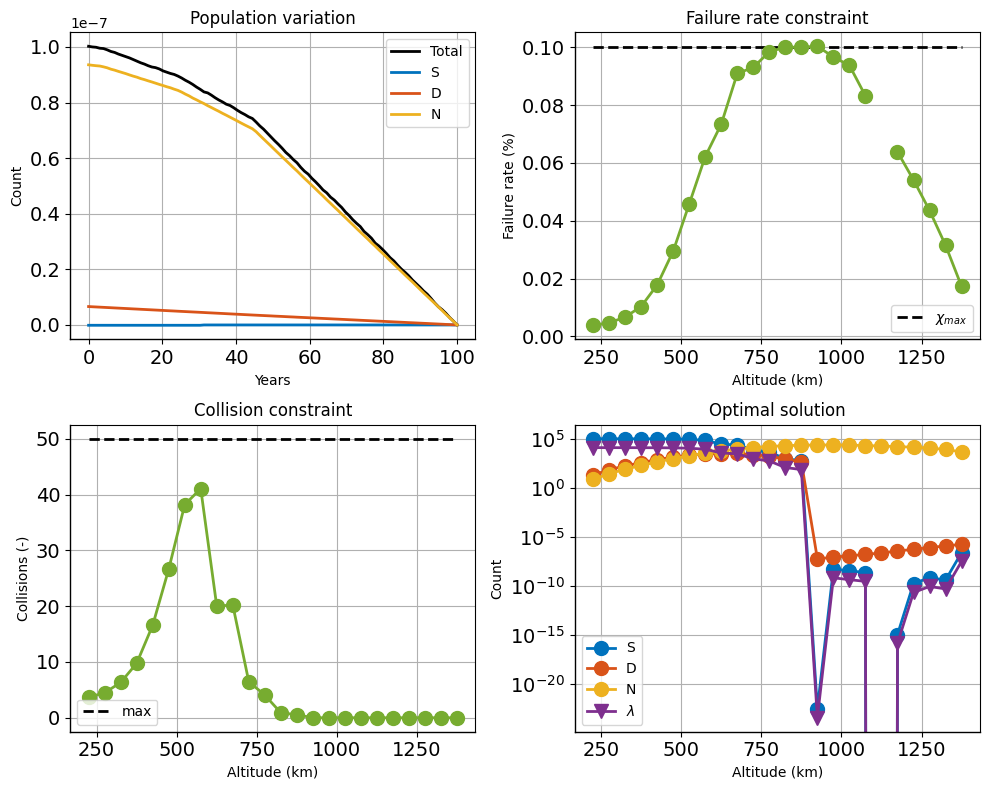

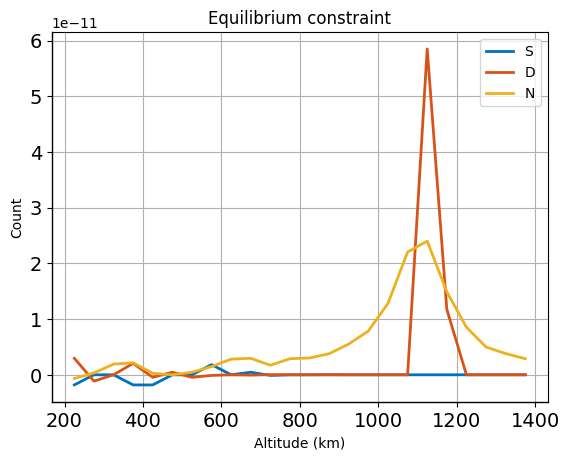

In [192]:
xopt = result.x

S_opt = xopt[0:N_shell]
N_opt = xopt[N_shell:2*N_shell] 
D_opt = xopt[2*N_shell:3*N_shell]
lam_opt = xopt[3*N_shell:4*N_shell]

c_eq = np.array([sp.lambdify(var_c, eq, 'numpy')(*xopt) for eq in equations_flattened])
S_eq = c_eq[0:N_shell]
N_eq = c_eq[N_shell:2*N_shell]
D_eq = c_eq[2*N_shell:3*N_shell]

fun3 = sp.lambdify((var_s, lam_s), f3, 'numpy')

def func(t, x, fun3, lam_opt):
    """ODE system function for solve_ivp."""
    return np.array(fun3(x, np.array(lam_opt))).flatten()

tf_ss = 100
tspan1 = np.linspace(0, tf_ss, 100)
sol = solve_ivp(func, (0, tf_ss), xopt[:3*N_shell], 
                method=baseline.integrator,
                t_eval=tspan1, 
                args=(fun3,lam_opt),
                rtol=1e-8, atol=1e-8)

t_prop = sol.t
x_prop = sol.y

S_prop = x_prop[0:N_shell]
N_prop = x_prop[N_shell:2*N_shell]
D_prop = x_prop[2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
# N_tot = S_prop + N_prop
N_tot_sum = sum(N_tot,2)
S_sum = sum(S_prop,2)
D_sum = sum(D_prop,2)
N_sum = sum(N_prop,2)

# Plots
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 2
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14
deltat = 8

# plt.figure(facecolor='w')
# plt.grid(True)
# plt.plot(t_prop, N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
# plt.plot(t_prop, S_sum, color=colors[1], linewidth=sel_LineWidth)
# plt.plot(t_prop, D_sum, color=colors[2], linewidth=sel_LineWidth)
# plt.plot(t_prop, N_sum, color=colors[3], linewidth=sel_LineWidth)
# plt.title("Population")
# plt.xlabel("Years")
# plt.ylabel("Count")
# plt.legend(["Total", "S", "D", "N"], loc="best")
# plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
# plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
# plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# # plt.savefig("so_variation_no_fail.pdf", dpi=300)  

# plt.figure(facecolor='w')
# plt.grid(True)
# plt.plot(t_prop, N_tot_sum[-1] - N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
# plt.plot(t_prop, S_sum[-1] - S_sum, color=colors[1], linewidth=sel_LineWidth)
# plt.plot(t_prop, D_sum[-1] - D_sum, color=colors[2], linewidth=sel_LineWidth)
# plt.plot(t_prop, N_sum[-1] - N_sum, color=colors[3], linewidth=sel_LineWidth)
# plt.title("Population variation")
# plt.xlabel("Years")
# plt.ylabel("Count")
# plt.legend(["Total", "S", "D", "N"], loc="best")
# plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
# plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
# plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# # plt.savefig("so_variation_no_fail.pdf", dpi=300)  

# plt.figure(facecolor='w')
# plt.grid(True)
# plt.plot(R02[1:] - 25, 100 * failure_rate_U * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
# plt.plot(R02[1:] - 25, 100 * (deltat * lam_opt - S_opt) / (deltat * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
# plt.title("Failure rate constraint")
# plt.xlabel("Altitude (km)")
# plt.ylabel("Failure rate (%)")
# plt.legend(["$\chi_{max}$"], loc="best")
# plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
# plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
# plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# # plt.savefig("fail_rate_no_fail.pdf", dpi=300)  

# plt.figure(facecolor='w')
# plt.grid(True)
# plt.plot(R02[1:] - 25, max_collis * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
# plt.plot(R02[1:] - 25, deltat * lam_opt - S_opt, '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
# plt.title("Collision constraint")
# plt.xlabel("Altitude (km)")
# plt.ylabel("Collisions (-)")
# plt.legend(["max"], loc="best")
# plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
# plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
# plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)

# plt.figure(facecolor='w')
# plt.semilogy(R02[1:] - 25, S_opt, '-o', color=colors[1], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
# plt.grid(True)
# plt.semilogy(R02[1:] - 25, D_opt, '-o', color=colors[2], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
# plt.semilogy(R02[1:] - 25, N_opt, '-o', color=colors[3], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
# plt.semilogy(R02[1:] - 25, lam_opt, '-v', color=colors[4], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
# plt.title("Optimal solution")
# plt.xlabel("Altitude (km)")
# plt.ylabel("Count")
# plt.legend(["S", "D", "N", "$\lambda$"], loc="best")
# plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
# plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
# plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.ylim(10,2e7)
# # plt.savefig("max_capacity_no_fail.pdf", dpi=300)  


# Create Subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), facecolor='w') # 2 rows, 2 columns

# Plot 1: Population Variation
axes[0, 0].grid(True)
axes[0, 0].plot(t_prop, N_tot_sum[-1] - N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
axes[0, 0].plot(t_prop, S_sum[-1] - S_sum, color=colors[1], linewidth=sel_LineWidth)
axes[0, 0].plot(t_prop, D_sum[-1] - D_sum, color=colors[2], linewidth=sel_LineWidth)
axes[0, 0].plot(t_prop, N_sum[-1] - N_sum, color=colors[3], linewidth=sel_LineWidth)
axes[0, 0].set_title("Population variation")
axes[0, 0].set_xlabel("Years")
axes[0, 0].set_ylabel("Count")
axes[0, 0].legend(["Total", "S", "D", "N"], loc="best")
axes[0, 0].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[0, 0].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[0, 0].spines['left'].set_linewidth(sel_LineWidthAxis)


# Plot 2: Failure Rate Constraint
axes[0, 1].grid(True)
axes[0, 1].plot(R02[1:] - 25, 100 * failure_rate_U * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
axes[0, 1].plot(R02[1:] - 25, 100 * (deltat * lam_opt - S_opt) / (deltat * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
axes[0, 1].set_title("Failure rate constraint")
axes[0, 1].set_xlabel("Altitude (km)")
axes[0, 1].set_ylabel("Failure rate (%)")
axes[0, 1].legend(["$\chi_{max}$"], loc="best")
axes[0, 1].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[0, 1].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[0, 1].spines['left'].set_linewidth(sel_LineWidthAxis)

# Plot 3: Collision Constraint
axes[1, 0].grid(True)
axes[1, 0].plot(R02[1:] - 25, max_collis * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
axes[1, 0].plot(R02[1:] - 25, deltat * lam_opt - S_opt, '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
axes[1, 0].set_title("Collision constraint")
axes[1, 0].set_xlabel("Altitude (km)")
axes[1, 0].set_ylabel("Collisions (-)")
axes[1, 0].legend(["max"], loc="best")
axes[1, 0].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[1, 0].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[1, 0].spines['left'].set_linewidth(sel_LineWidthAxis)

# Plot 4: Optimal Solution
axes[1, 1].semilogy(R02[1:] - 25, S_opt, '-o', color=colors[1], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
axes[1, 1].grid(True)
axes[1, 1].semilogy(R02[1:] - 25, D_opt, '-o', color=colors[2], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
axes[1, 1].semilogy(R02[1:] - 25, N_opt, '-o', color=colors[3], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
axes[1, 1].semilogy(R02[1:] - 25, lam_opt, '-v', color=colors[4], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
axes[1, 1].set_title("Optimal solution")
axes[1, 1].set_xlabel("Altitude (km)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].legend(["S", "D", "N", "$\lambda$"], loc="best")
axes[1, 1].tick_params(axis='both', which='major', labelsize=sel_FontSize)
axes[1, 1].spines['bottom'].set_linewidth(sel_LineWidthAxis)
axes[1, 1].spines['left'].set_linewidth(sel_LineWidthAxis)
# axes[1, 1].set_ylim(10,2e7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


plt.figure(facecolor='w')
plt.grid(True)
plt.plot(R02[1:] - 25, S_eq, color=colors[1], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, D_eq, color=colors[2], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, N_eq, color=colors[3], linewidth=sel_LineWidth)
plt.title("Equilibrium constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("equil_constr_no_fail.pdf", dpi=300)  


(1.0, 200000.0)

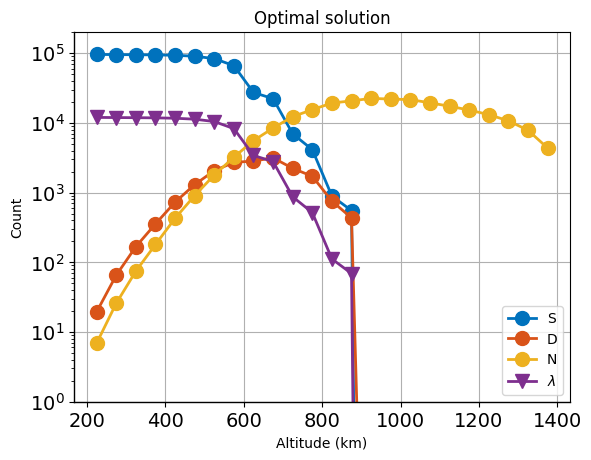

In [193]:
plt.figure(facecolor='w')
plt.semilogy(R02[1:] - 25, S_opt, '-o', color=colors[1], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.grid(True)
plt.semilogy(R02[1:] - 25, D_opt, '-o', color=colors[2], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, N_opt, '-o', color=colors[3], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, lam_opt, '-v', color=colors[4], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Optimal solution")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N", "$\lambda$"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
plt.ylim(1e0,2e5)

/var/folders/8r/pmy63vtd1lbbfd8ptmtgcr4w0000gn/T/ipykernel_84056/4240680078.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(R02[1:] - 25, 100 * (deltat * lam_opt - S_opt) / (deltat * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)


(0.0, 0.12)

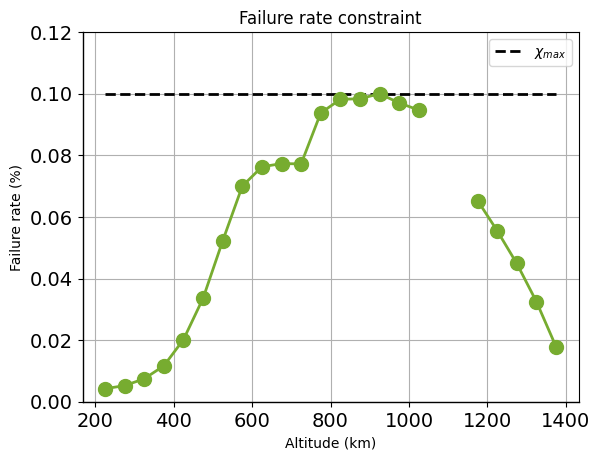

In [175]:
plt.figure(facecolor='w')
plt.grid(True)
plt.plot(R02[1:] - 25, 100 * failure_rate_U * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, 100 * (deltat * lam_opt - S_opt) / (deltat * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Failure rate constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Failure rate (%)")
plt.legend(["$\chi_{max}$"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
plt.ylim(0,0.12)
